# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 


### Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from moviepy.editor import VideoFileClip
from IPython.display import HTML

import numpy as np
import cv2
import math
import os

%matplotlib inline

### Some initialization parameters

In [2]:
#initialize average slope and intercept for left and right lanes
avg_a_left, avg_b_left = [], []
avg_a_right, avg_b_right = [], []

#number of frames used for averaging 
n_frames = 10

### Helper Functions, with modified draw_lines()

In [3]:
def reset_lanes():
    """
    empties the average slopes and intercepts for left 
    and right lanes
    """
    del avg_a_left[:]
    del avg_b_left[:]
    del avg_a_right[:]
    del avg_b_right[:]

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.95, β=1.0, λ=0.0):
    return cv2.addWeighted(initial_img, α, img, β, λ)

### from here, my own functions
def hsl(image):
    """
    converts the input image from RGB to HSL space,
    for better filtering of the lanes based on color levels
    of white and yellow
    """

    # convert to HSL
    yellow = np.uint8([[[255, 255, 0]]])

    # what is yellow in HSL?
    img2 = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)         
    yellow_conv = cv2.cvtColor(yellow, cv2.COLOR_RGB2HLS) 
    
    # tweak thresholds to capture yellow lanes
    low_y = np.uint8([10, 0, 100]);                      
    high_y = np.uint8([50, 255, 255]);
    
    # what is white in HSL ?
    white = np.uint8([[[255, 255, 255]]])                
    white_conv = cv2.cvtColor(white, cv2.COLOR_RGB2HLS)   
    
    # tweak thresholds to capture white lanes
    low_w = np.uint8([0, 210, 0])                         
    high_w = np.uint8([200, 255, 255])
    
    #create white and yellow masks
    yellow_mask = cv2.inRange(img2, low_y, high_y)        
    white_mask = cv2.inRange(img2, low_w, high_w)

    #combine masks
    total_mask = cv2.bitwise_or(white_mask, yellow_mask) 
    final_img = cv2.bitwise_and(image, image, mask = total_mask) 

    #return HSL image filtered for white and yellow
    return final_img

def line_slope(line):
    """
    returns the slope of a line in, degrees
    """
    for x1, y1, x2, y2 in line:
        return np.degrees(np.arctan(float((y2-y1))/(x2-x1)))

def interp_lines(lines):
    """
    returns the a and b coefficients (y = ax + b) from a list of x and y points
    """
    x = []
    y = []
    for line in lines:
        x.append(line[0][0])  # first point of line
        x.append(line[0][2])
        y.append(line[0][1])  # second point of line
        y.append(line[0][3])

    coeff = np.polyfit(x, y, 1)

    return coeff

def avg_params_n_frames(coeffs, left = True):
    """
    calculate the average a and be coefficients for a given lane, from the last n_frames
    """
    if left:
        if coeffs[0] == None: #if interpolation fails, return right away
            return np.mean(avg_a_left), np.mean(avg_b_left)

        avg_a_left.append(coeffs[0])
        avg_b_left.append(coeffs[1])

        if (len(avg_a_left) > n_frames): avg_a_left.pop(0) #only keep the last n_frames values
        if (len(avg_b_left) > n_frames): avg_b_left.pop(0)

        return np.mean(avg_a_left), np.mean(avg_b_left)

    else:
        if coeffs[0] == None: #if interpolation fails, return right away
            return np.mean(avg_a_right), np.mean(avg_b_right)

        avg_a_right.append(coeffs[0])
        avg_b_right.append(coeffs[1])

        if (len(avg_a_right) > n_frames): avg_a_right.pop(0) #only keep the last n_frames values
        if (len(avg_b_right) > n_frames): avg_b_right.pop(0)

        return np.mean(avg_a_right), np.mean(avg_b_right)

def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    draws left and right lanes
    """
    img_x = img.shape[1]
    img_y = img.shape[0]

    neg_slope  = []
    pos_slope  = []

    # remove lines that are close to horizontal
    # only keep lines that have slopes between 25 and 40 degrees
    no_horiz = [line for line in lines if abs(line_slope(line)) > 25 and abs(line_slope(line)) < 40]
    for line in no_horiz:
        if line_slope(line) < 0: neg_slope.append(line)
        else: pos_slope.append(line)

    # get the y = ax + b line from all the points in the negative slope list of lines (left lane)
    neg_coeff = interp_lines(neg_slope)
    cur_a_left, cur_b_left = avg_params_n_frames(neg_coeff, left = True)
   
    # get the y = ax + b line from all the points in the positive slope list of lines (right lane)
    pos_coeff = interp_lines(pos_slope)
    cur_a_right, cur_b_right = avg_params_n_frames(pos_coeff, left = False)
    
    #draw the left lane
    cv2.line(img, (int((0.6*img_y - cur_b_left)/cur_a_left), int(0.6*img_y)), \
                  (int((img_y - cur_b_left)/cur_a_left), img_y), color, thickness)

    #draw the right line
    cv2.line(img, (int((0.6*img_y - cur_b_right)/cur_a_right), int(0.6*img_y)), \
                  (int((img_y - cur_b_right)/cur_a_right), img_y), color, thickness)

### Image processing pipeline

In [4]:
def process_image(image):
    """
    image processing pipeline
    """
    im_y = image.shape[0]
    im_x = image.shape[1]

    rgb2hsl = hsl(image)             
    gray = grayscale(rgb2hsl)
    blur_gray = gaussian_blur(gray, 11) 
    edges = canny(blur_gray, 80, 160)
    crop_verts = np.array([[(int(0.1*im_x), im_y), (int(0.95*im_x), im_y), (int(0.55*im_x), int(0.6*im_y)), (int(0.4*im_x),\
                             int(0.6*im_y)), (int(0.1*im_x), im_y)]], dtype = np.int32)    

    canny_cropped = region_of_interest(edges, crop_verts)
    
    #Hough space parameters
    max_line_gap = 250
    min_line_len = 20
    rho = 1
    theta = 1*np.pi/180
    threshold = 10

    houghed_img = hough_lines(canny_cropped,max_line_gap=max_line_gap, min_line_len = min_line_len, rho = rho, theta = theta, threshold = threshold)
    
    result = weighted_img(houghed_img, image)
    return result

### Now, test it on the test images, showing a few stages of the pipeline for each image

In [5]:
def test_images():
    """
    applies the pipeline to all test images
    """
    dir_name = "test_images/"
    all_files = os.listdir(dir_name)

    n_files = len(all_files)

    idx = 0
    
    plt.figure(figsize = (10, 8))
    for file in all_files:
        image = mpimg.imread(dir_name + file)

        im_x = image.shape[1]
        im_y = image.shape[0]

        reset_lanes()
        #original image
        plt.subplot(n_files, 5, idx + 1)
        plt.imshow(image, origin = 'upper')
        plt.tick_params(axis = 'x', labelbottom = 'off', bottom = 'off')
        plt.tick_params(axis = 'y', labelleft = 'off', left = 'off')
        if (idx < 1):
            plt.title('original')

        #hsl image
        plt.subplot(n_files, 5, idx + 2)
        rgb2hsl = hsl(image)
        plt.imshow(rgb2hsl, origin = 'upper')
        plt.tick_params(axis = 'x', labelbottom = 'off', bottom = 'off')
        plt.tick_params(axis = 'y', labelleft = 'off', left = 'off')
        if (idx < 1):
            plt.title('HSL space') 

        #gray and blurred image
        plt.subplot(n_files, 5, idx + 3)
        gray = grayscale(rgb2hsl)
        blur_gray = gaussian_blur(gray, 11) 
        plt.imshow(blur_gray, origin = 'upper')
        plt.tick_params(axis = 'x', labelbottom = 'off', bottom = 'off')
        plt.tick_params(axis = 'y', labelleft = 'off', left = 'off')
        if (idx < 1):
            plt.title('gray, blurred')
            
        #canny cropped image
        plt.subplot(n_files, 5, idx + 4)
        edges = canny(blur_gray, 80, 160)
        crop_verts = np.array([[(int(0.1*im_x), im_y), (int(0.95*im_x), im_y), (int(0.55*im_x), int(0.6*im_y)), (int(0.4*im_x),\
                                 int(0.6*im_y)), (int(0.1*im_x), im_y)]], dtype = np.int32)    
        canny_cropped = region_of_interest(edges, crop_verts)
        plt.imshow(canny_cropped, origin = 'upper')
        plt.tick_params(axis = 'x', labelbottom = 'off', bottom = 'off')
        plt.tick_params(axis = 'y', labelleft = 'off', left = 'off')
        if (idx < 1):
            plt.title('Canny')

        #final detected lines
        plt.subplot(n_files, 5, idx + 5)
        max_line_gap = 250
        min_line_len = 20
        rho = 1
        theta = 1*np.pi/180
        threshold = 10

        houghed_img = hough_lines(canny_cropped,max_line_gap=max_line_gap, min_line_len = min_line_len, rho = rho, theta = theta, threshold = threshold)
        result = weighted_img(houghed_img, image)
        plt.imshow(result, origin = 'upper')
        plt.tick_params(axis = 'x', labelbottom = 'off', bottom = 'off')
        plt.tick_params(axis = 'y', labelleft = 'off', left = 'off')
        if (idx < 1):
            plt.title('detected lanes')
        
        #move to next row
        idx += 5

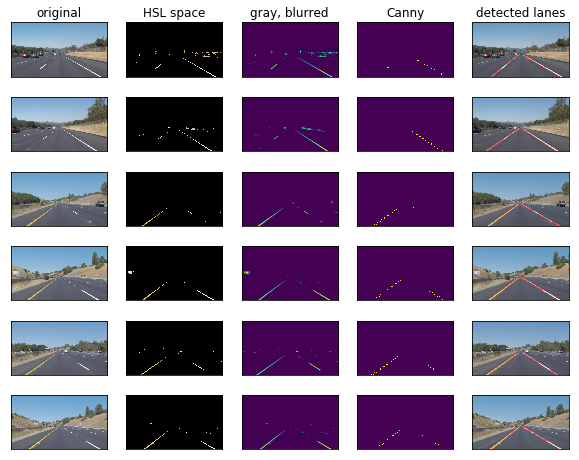

In [6]:
test_images()

### Apply it on the test videos, including the challenge one

In [7]:
def process_video(fname):
    """
    process the video named fname
    """
    if fname == None:
        return

    #have to reset lanes
    reset_lanes()

    input_file = "test_videos/" + fname + ".mp4"
    output = "test_videos_output/" + fname + ".mp4"
    input_file = VideoFileClip(input_file)
    processed_file = input_file.fl_image(process_image)
    processed_file.write_videofile(output, audio = False)

In [8]:
process_video("solidWhiteRight")

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:03<00:00, 67.30it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 



In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("test_videos_output/solidWhiteRight.mp4"))

In [10]:
process_video("solidYellowLeft")

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:10<00:00, 64.23it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 



In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("test_videos_output/solidYellowLeft.mp4"))

In [12]:
process_video("challenge")

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:08<00:00, 30.85it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 



In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("test_videos_output/challenge.mp4"))

### End of notebook, the py version of this code can be found in P1.py